In [55]:
import sys
from pathlib import Path

import pandas as pd
import geopandas as gpd

import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
from IPython.display import IFrame

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all

In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
dfs['geocode'].head()

,Unnamed: 0,Lab Id,Address,Location,Zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469


In [4]:
dfs['transactional'].head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,10.0


In [5]:
# Padroniza os zipcodes
dfs['geocode']['Zipcode'] = dfs['geocode']['Zipcode'].astype(str).str.split('.').str[0].str.zfill(5)

# Merge para adicionar ZCTA ao dataset de exames
dfs['transactional'] = dfs['transactional'].merge(dfs['geocode'][['Lab Id', 'Zipcode']], on='Lab Id', how='left')
dfs['transactional'].rename(columns={'Zipcode': 'ZCTA'}, inplace=True)

# Converte a coluna de data
dfs['transactional']['Date of service'] = pd.to_datetime(dfs['transactional']['Date of service'], errors='coerce')

dfs['transactional'][['Date of service', 'ZCTA']].head()

,Date of service,ZCTA
0,2019-01-07,94565
1,2019-01-07,94565
2,2019-01-07,94565
3,2019-01-07,94565
4,2019-01-07,94565


In [9]:
# Data mais recente do dataset
data_max = dfs['transactional']['Date of service'].max()
print(f"Última data disponível: {data_max.date()}")

# Define o limite inferior
data_limite = data_max - pd.DateOffset(years=1)
df_recent = dfs['transactional'][dfs['transactional']['Date of service'] >= data_limite].copy()

# Agrupa por ZCTA
df_exames_recentes = df_recent.groupby('ZCTA').size().reset_index(name='num_exames_recentes')

df_exames_recentes.sort_values(by='num_exames_recentes', ascending=False).head(10)

Última data disponível: 2021-02-12


,ZCTA,num_exames_recentes
82,94565,25156
88,95823,18008
52,30096,17599
90,98008,16941
40,19143,14038
94,98034,13597
43,19148,13324
53,30135,13176
89,98004,12976
37,19120,12748


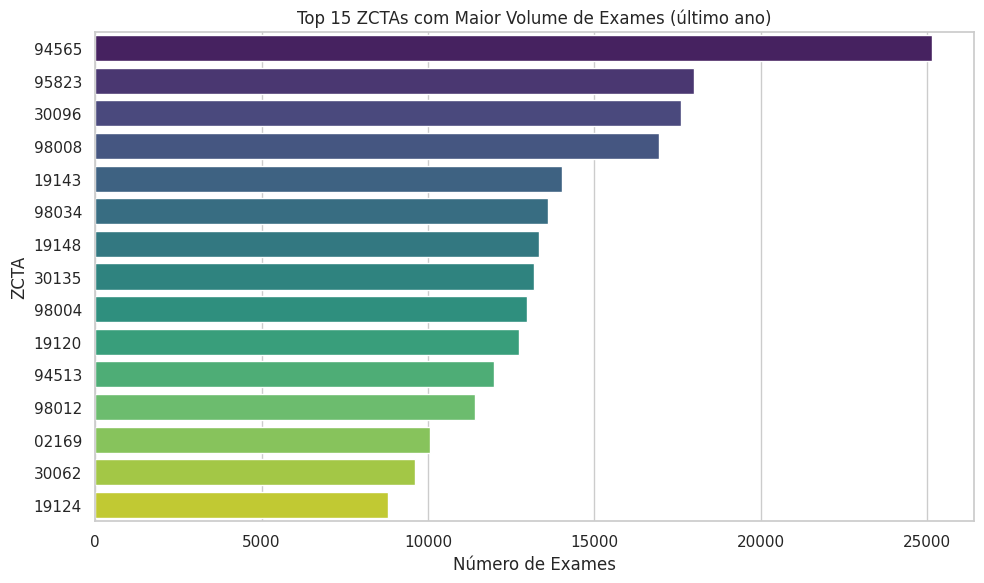

In [14]:
# Seleciona os top 15 ZCTAs com mais exames
top_zctas = df_exames_recentes.sort_values(by='num_exames_recentes', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_zctas,
    x='num_exames_recentes',
    y='ZCTA',
    hue='ZCTA',
    palette='viridis',
    legend=False
)
plt.title('Top 15 ZCTAs com Maior Volume de Exames (último ano)')
plt.xlabel('Número de Exames')
plt.ylabel('ZCTA')
plt.tight_layout()
plt.show()

In [13]:
if 'ZCTA' not in dfs['demographic'].columns:
    dfs['demographic']['ZCTA'] = dfs['demographic']['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')[0]

# Merge dos exames recentes com dados demográficos
h2a_df = df_exames_recentes.merge(
    dfs['demographic'][['ZCTA', 'TotalPopulation', 'MedianAgeInYears']],
    on='ZCTA',
    how='left'
)

# Visualiza os principais
h2a_df.sort_values(by='num_exames_recentes', ascending=False).head(10)

,ZCTA,num_exames_recentes,TotalPopulation,MedianAgeInYears
82,94565,25156,97671.0,34.1
88,95823,18008,79440.0,31.4
52,30096,17599,68691.0,35.8
90,98008,16941,25719.0,42.3
40,19143,14038,64630.0,32.9
94,98034,13597,43471.0,36.8
43,19148,13324,52259.0,36.4
53,30135,13176,67710.0,37.7
89,98004,12976,36202.0,37.8
37,19120,12748,74060.0,30.2


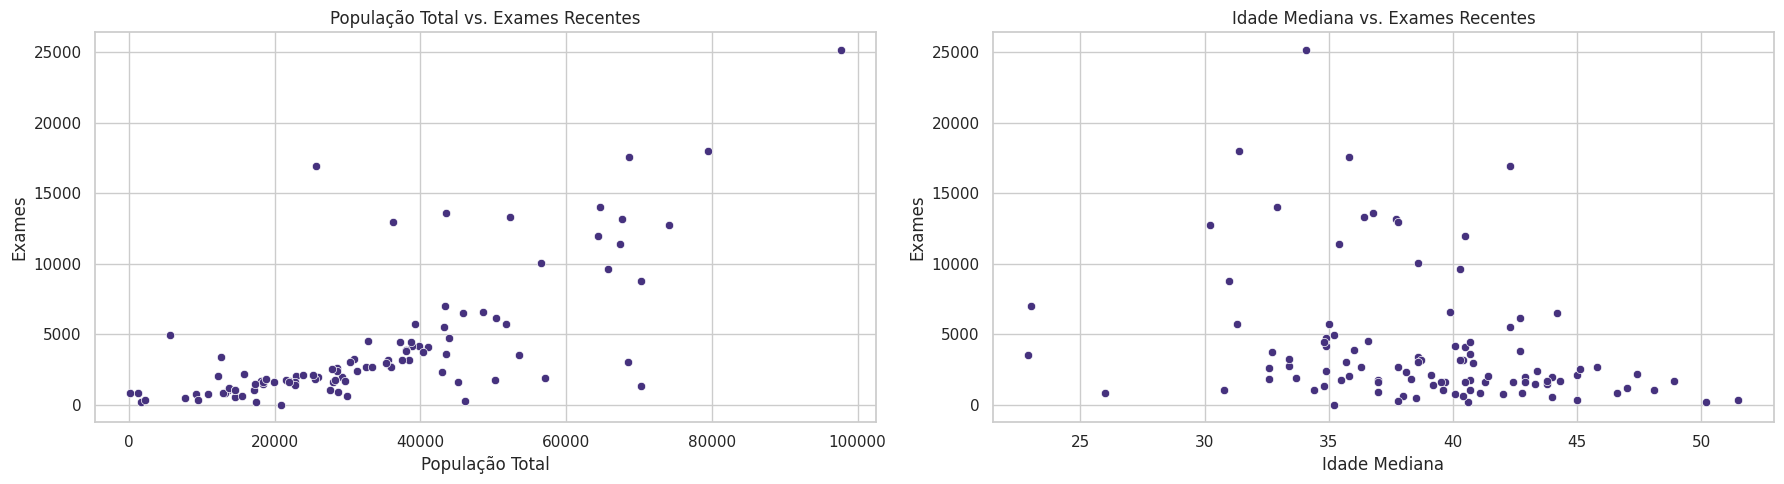

In [18]:
# Remove possíveis nulos
h2a_df = h2a_df.dropna(subset=['TotalPopulation', 'MedianAgeInYears', 'num_exames_recentes'])

# Criação dos plots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.scatterplot(data=h2a_df, x='TotalPopulation', y='num_exames_recentes', ax=axes[0])
axes[0].set_title('População Total vs. Exames Recentes')
axes[0].set_xlabel('População Total')
axes[0].set_ylabel('Exames')

sns.scatterplot(data=h2a_df, x='MedianAgeInYears', y='num_exames_recentes', ax=axes[1])
axes[1].set_title('Idade Mediana vs. Exames Recentes')
axes[1].set_xlabel('Idade Mediana')
axes[1].set_ylabel('Exames')

plt.tight_layout()
plt.show()


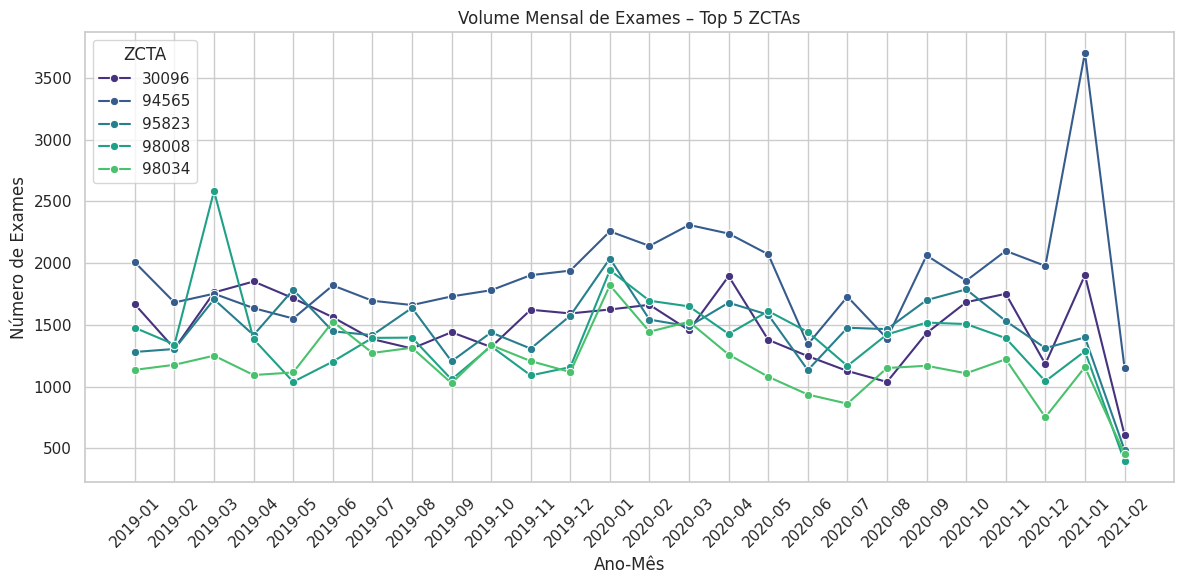

In [21]:
# Extrai ano-mês
dfs['transactional']['YearMonth'] = dfs['transactional']['Date of service'].dt.to_period('M').astype(str)

# Agrupa por ZCTA e mês
df_series = dfs['transactional'].groupby(['YearMonth', 'ZCTA']).size().reset_index(name='num_exames')

# Seleciona os Top 5 ZCTAs com maior volume total
top_zctas = (
    df_series.groupby('ZCTA')['num_exames'].sum()
    .sort_values(ascending=False).head(5).index.tolist()
)

# Filtra somente esses ZCTAs
df_top_series = df_series[df_series['ZCTA'].isin(top_zctas)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_series, x='YearMonth', y='num_exames', hue='ZCTA', marker='o')
plt.title('Volume Mensal de Exames – Top 5 ZCTAs')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


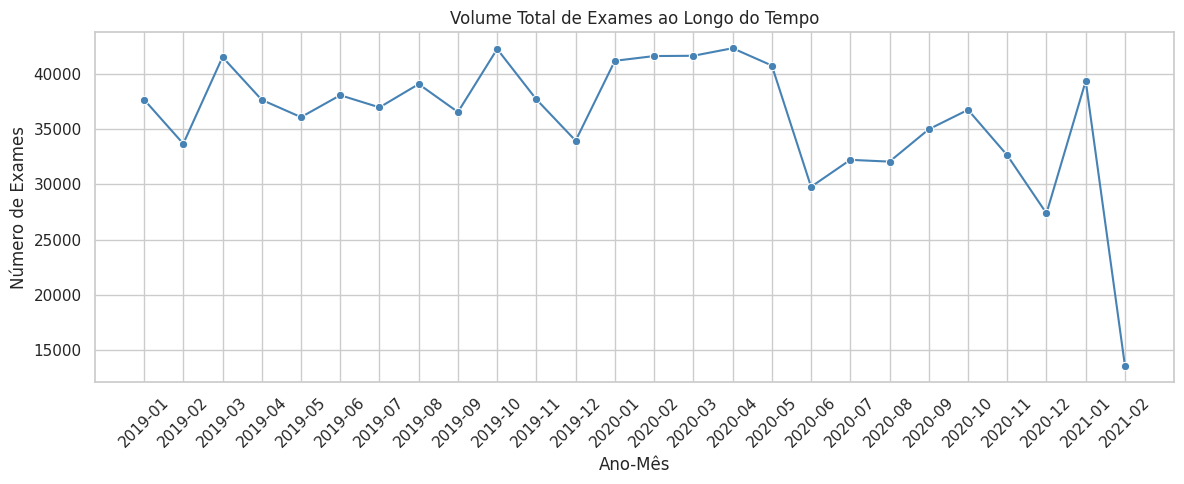

In [22]:
# Agrupa por mês e soma exames
df_global_series = dfs['transactional'].groupby('YearMonth').size().reset_index(name='num_exames')

# Ordena datas corretamente
df_global_series = df_global_series.sort_values(by='YearMonth')

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_global_series, x='YearMonth', y='num_exames', marker='o', color='steelblue')
plt.title('Volume Total de Exames ao Longo do Tempo')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📊 H2a – ZCTAs com Maior Volume de Exames Indicam Maior Potencial Futuro

A análise temporal dos dados demonstra que:

- Os principais ZCTAs (como 94565, 95823 e 30096) mantêm volume elevado e relativamente estável ao longo do tempo.
- O volume total da rede foi consistente até o início da pandemia, com queda temporária e posterior retomada.
- Esses comportamentos reforçam a hipótese de que **ZCTAs com histórico de alta demanda** representam **potencial futuro promissor**, principalmente quando combinados com características demográficas favoráveis.

> Conclusão: **H2a é suportada pelos dados históricos**, tanto em nível local (ZCTA) quanto geral.


In [33]:
zcta_gdf = gpd.read_file("../data/zcta_subset.geojson")

In [63]:
# Contagem de exames por ZCTA
df_exames_por_zcta = dfs['transactional'].groupby('ZCTA').size().reset_index(name='num_exames')

# Top 15 ZCTAs com mais exames
top_zctas = (
    df_exames_por_zcta.sort_values(by='num_exames', ascending=False)
    .head(30)
)

# Conta labs por ZCTA
labs_por_zcta = dfs['geocode'].groupby('Zipcode').size().reset_index(name='num_labs')

# Merge com top_zctas
top_zctas_df = top_zctas.merge(labs_por_zcta, left_on='ZCTA', right_on='Zipcode', how='left')
top_zctas_df['num_labs'] = top_zctas_df['num_labs'].fillna(0).astype(int)

# Filtra geometria só das top ZCTAs
top15_geo = zcta_gdf[zcta_gdf['ZCTA5CE20'].isin(top_zctas_df['ZCTA'])].copy()

# Junta com num_labs
top15_geo = top15_geo.merge(
    top_zctas_df[['ZCTA', 'num_labs', 'num_exames']],
    left_on='ZCTA5CE20',
    right_on='ZCTA',
    how='left'
)

top_zctas_df.head()

,ZCTA,num_exames,Zipcode,num_labs
0,94565,49475,94565,1
1,30096,38511,30096,1
2,95823,38128,95823,1
3,98008,35935,98008,1
4,98034,30495,98034,3


In [64]:
# 1. Projeta para um CRS métrico adequado (ex: Albers USA)
top15_proj = top15_geo.to_crs(epsg=5070)

# 2. Calcula o centróide no sistema projetado
top15_proj['centroid'] = top15_proj.geometry.centroid

# 3. Transforma de volta para latitude/longitude (EPSG:4326)
top15_proj = top15_proj.set_geometry('centroid').to_crs(epsg=4326)

# 4. Extrai lat/lon
top15_geo['lat'] = top15_proj.geometry.y.values
top15_geo['lon'] = top15_proj.geometry.x.values

# Prepara dados para o HeatMap
heat_data = top15_geo[['lat', 'lon', 'num_exames']].dropna().values.tolist()

top15_geo_clean = top15_geo.drop(columns=['centroid', 'lat', 'lon'], errors='ignore')

m = folium.Map(location=[39.5, -98.35], zoom_start=4)

# Choropleth para apenas as 15 ZCTAs, colorindo por número de labs
folium.Choropleth(
    geo_data=top15_geo_clean.to_json(),
    name='Top 15 ZCTAs – Número de Laboratórios',
    data=top15_geo,
    columns=['ZCTA5CE20', 'num_labs'],
    key_on='feature.properties.ZCTA5CE20',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Número de Laboratórios'
).add_to(m)

HeatMap(heat_data, radius=25, blur=15, max_zoom=10).add_to(m)

# Tooltip opcional com número de exames
for _, row in top15_geo.iterrows():
    popup_text = f"ZCTA: {row['ZCTA5CE20']}<br>Exames: {row['num_exames']}<br>Labs: {row['num_labs']}"
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0},
        tooltip=popup_text
    ).add_to(m)

m.save("../reports/top15_zctas_labs.html")

In [65]:
IFrame('../reports/top15_zctas_labs.html', width=900, height=600)